# Stuff to do
Current Problem Statement: How similar and different are two channels who have nearly the same content, but one with a positive perspective and the other with a negative

Original Problem Statement: Through sentimitation, can we learn which channels have the most positive and negative communities?
#### Bonuses
 - Latient Dirilech Analysis
 - Topic system
 - Function to guess/estimate how many comments a channel has
 - Model prediction how many comments will happen over time (based on views and topic)

## Imports

In [1]:
import requests
import time
import pandas as pd
import warnings
import numpy as np      
#import regex as re
from random import sample
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from random import seed

from textblob import TextBlob
import textstat

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
import re # Delete this if scraping in same notebook

tokenizer = RegexpTokenizer(r'\w+')

def preprocess(text):
    text = re.sub(r'[^a-zA-Z]',' ', text.lower())
    tokens = word_tokenize(text)
    lemmer = WordNetLemmatizer()
    stop_words = stopwords.words("english")
    return " ".join([lemmer.lemmatize(word) for word in tokens if len(word) > 1 and not word in stop_words])
cvec = CountVectorizer(analyzer = "word",
                       tokenizer = tokenizer.tokenize,
                       preprocessor = preprocess,
                       stop_words = 'english',
                       min_df = 2)

## Function Definitions

In [3]:
def Sentamentize(text):
    return TextBlob(str(text)).sentiment.polarity

In [4]:
def correlate(df, Target_column):
    # Initalize the things
    columns = [a for a in df.columns]
    the_dict = {}
    
    #Loop for each coumn and the target
    for item in columns:
        the_dict[str(item)] = df[Target_column].corr(df[item])
    the_list = [the_dict]
    
    # Init df and shape it how would be best
    corr_df = pd.DataFrame(the_list).drop(Target_column, axis = 1).T#.rename
    corr_df.rename({0:'Correlation'}, axis = 1, inplace= True)
    return pd.DataFrame(corr_df['Correlation'].sort_values())#.reset_index()
    #return corr_df

In [5]:
def LDA(input_item, num_topics = 3, num_words = 5, pre_cveced = False):
    # Cols are the words. Rows are the topics
    topic_lists = []
    lda = LatentDirichletAllocation(n_components=num_topics, learning_method='online')
    
    if  pre_cveced == False: # For inserting a column and automatically cvecing things in function.
        lda.fit(cvec.fit_transform(input_item))
    elif pre_cveced == True: # For inserting a pre-cveced dataframe.
        lda.fit(input_item)
    else:
        print("Not good pre_cveced option given.")
    for ix, topic in enumerate(lda.components_):
        topic_lists += [[cvec.get_feature_names()[i] for i 
                         in lda.components_[ix].argsort()[:-num_words - 1:-1]]]

    return pd.DataFrame(topic_lists, columns=[ 'word_' + str(i) for i 
                                    in range(1, num_words+1)], index=range(1, num_topics + 1)) 

## Importing and editing the data as need be

In [6]:
wins_df = pd.read_csv('../Laboritory/data/wins_with_sins')
sins_df = pd.read_csv('../Laboritory/data/sins_with_wins')
wins_df['is_a_win'] = 1
sins_df['is_a_win'] = 0

In [7]:
sample_percentage = .25
samp = round(((wins_df.shape[0] + sins_df.shape[0]) * sample_percentage)/2)
print('Number of Wins:', wins_df.shape[0])
print('Number of Sins:', sins_df.shape[0])
print('Sug samp of ea: ', samp)

Number of Wins: 131004
Number of Sins: 354643
Sug samp of ea:  60706


In [8]:
samp = 50000
print('Percentage of total pop:',
    (samp/(wins_df.shape[0] + sins_df.shape[0]))*2)

Percentage of total pop: 0.20591087765393382


In [9]:
random.seed(76)


# Creating mask which will act as the sample for the Wins
mask = random.sample([i for i in range(wins_df.shape[0])], samp)
w_samp = wins_df.loc[mask, ['text','is_a_win']]

# Creating mask which will act as the sample for the Sins
mask = random.sample([i for i in range(sins_df.shape[0])], samp)
s_samp = sins_df.loc[mask, ['text','is_a_win']]

# Sticking the sampled dfs together
sampled_df = pd.concat([w_samp,s_samp])

# Cleaning
sampled_df.dropna(inplace= True)
sampled_df.reset_index(inplace = True)

# Creating the cvec df
df = pd.DataFrame(cvec.fit_transform(sampled_df['text']).todense(),
    columns=cvec.get_feature_names())

df['is_win'] = sampled_df['is_a_win']

#print(len(df['is_a_win']))
print(df.shape)

(99973, 18944)


In [10]:
correlation_df = correlate(df, 'is_win')

In [11]:
mask = abs(correlation_df['Correlation']) > 0.01
features = [word for word in correlation_df[mask].index]

# EDA, Insights and Results

### Correlations
Starting off, lets look at which words are most and least correlated to each channel

In [18]:
print("Words most correlated to CinemaSins videos and away from CinemaWins videos")
correlation_df.head(10)

Words most correlated to being a CinemaSins video and away from being a CinemaWins video


,Correlation
sin,-0.193750
wrong,-0.119747
minute,-0.061436
gravity,-0.058759
fucking,-0.053256
lol,-0.052602
shit,-0.048063
space,-0.047731
fuck,-0.046230
earth,-0.041294


In [19]:
print("Words most correlated to CinemaWins videos & away from CinemaSins videos")
correlation_df.tail(10)[::-1]

Words most correlated to being a CinemaWins video and away from being a CinemaSins video


,Correlation
bernthal,0.298802
jon,0.298676
win,0.141462
great,0.136825
cinemawins,0.083272
love,0.078522
film,0.069680
favorite,0.055620
vader,0.055078
martha,0.054447


### LDA of the channels

The following are some Latent Derelich Analysis of both channels.  This can give us a sense of which words are related most often in the comments.  As such they can give us an idea of the conversations taking place.

Each row is a topic and each column is a word in the topic from most relevant to said topic to less relevant.

In [14]:
LDA(w_samp['text'].dropna(), num_topics = 4, num_words = 8)

,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8
1,movie,great,film,best,love,star,really,loved
2,like,say,man,people,scene,think,war,got
3,jon,bernthal,reference,na,gon,music,rey,fuck
4,movie,like,video,win,love,good,really,character


In [15]:
LDA(s_samp['text'].dropna(), num_topics = 4, num_words = 8)

,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8
1,wrong,said,going,deadpool,got,gravity,space,say
2,shit,mean,sin,scene,fuck,end,god,wait
3,movie,sin,like,video,make,man,really,good
4,sin,minute,batman,game,le,wiggle,know,na


### The Sentiment numbers

In [16]:
wins_df['Sentiment'] = wins_df['text'].map(lambda x: Sentamentize(x))
sins_df['Sentiment'] = sins_df['text'].map(lambda x: Sentamentize(x))

print('Average Sentiment of Wins:',round(wins_df['Sentiment'].sum()/len(wins_df['Sentiment']), 2))
print('Average Sentiment of Sins:',round(sins_df['Sentiment'].sum()/len(sins_df['Sentiment']), 2))

Average Sentiment of Wins: 0.15
Average Sentiment of Sins: 0.04


Cool.  Based on these numbers we can tell that there is a difference between the sentiment of sins and wins, but it can be difficult to understand exactly what those two numbers mean.  Lets see some examples of comments which have those exact numbers.

In [49]:
random.seed(76)
mask = wins_df['Sentiment'] == 0.15
ex_samples = random.sample([x for x in wins_df[mask].index], 5)
print('WINS WITH SENTIMENT == 0.15')
print()
for comment in ex_samples:
    print(wins_df.loc[comment, 'text'])
    print('-----------------------------------------')

mask = wins_df['Sentiment'] == 0.04
ex_samples = random.sample([x for x in wins_df[mask].index], 5)
print()
print()
print('WINS WITH SENTIMENT == 0.04')
print()
for comment in ex_samples:
    print(wins_df.loc[comment, 'text'])
    print('-----------------------------------------')

WINS WITH SENTIMENT == 0.15

Well, the sequel is said to be about the duo traversing the internet to get a part to repair a game, with the trailer making it looks like the movie is going to show that Ralph is an old guy, not really understanding the internet.
Let's see if it's gonna be another sweet win or exploding a bunny in front of a child is going to wreck the scores
-----------------------------------------
Politely requesting
- Shaun of the dead
- Worlds end
- Baby driver
You do love Edgar Wright, Wright?
-----------------------------------------
I love how Disney handles the Sonic scene, where he blinks when he loses his Rings. This was a great video game movie.
-----------------------------------------
If you’re not crazy about musicals, I got a challenge for you; The Nightmare Before Christmas. I’m not a musical lover either, but that movie is one of my all time favorites.
-----------------------------------------
Patrick Stewart was 75-76 when they made this movie. It's real

In [48]:
random.seed(76)
mask = sins_df['Sentiment'] == 0.15
ex_samples = random.sample([x for x in sins_df[mask].index], 5)
print('SINS WITH SENTIMENT == 0.15')
print()
for comment in ex_samples:
    print(sins_df.loc[comment, 'text'])
    print('-------------------------------------------')

mask = sins_df['Sentiment'] == 0.04

ex_samples = random.sample([x for x in sins_df[mask].index], 5)
print()
print()
print('SINS WITH SENTIMENT == 0.04')

print()
for comment in ex_samples:
    print(sins_df.loc[comment, 'text'])
    print('-------------------------------------------')

SINS WITH SENTIMENT == 0.15

Why did you not sin the fact that they reused the same voice actors but the same characters... I'm pretty sure thats the same snake in Robin Hood.
-------------------------------------------
hes not fighting a normal man hes fighting GSP
-------------------------------------------
How did Baymax even end up in Tadashi's room when we first saw him at Tadashi's school o_o
-------------------------------------------
batman died. it was alfred imagining  bruce in a normal life.
-------------------------------------------
I think you should keep out your own personal tastes about the film as "sins", and only keep stuff which would be illogical, errors in movies and such
-------------------------------------------


SINS WITH SENTIMENT == 0.04

Sin 1: Admiral Marcus is the only person who knows about Khan and his plan to make war with the Klingons.Yet Khan attacks Starfleet over something that happened 300 years ago that the people personally had nothing to do wi

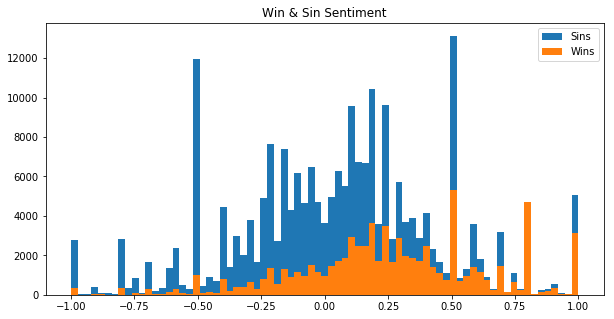

In [17]:
plt.figure(figsize = (10,5))

mask = sins_df['Sentiment'] != 0
plt.hist(sins_df[mask]['Sentiment'], bins = 75, label = 'Sins');
#plt.title('Sin Sentiment');

mask = wins_df['Sentiment'] != 0
plt.hist(wins_df[mask]['Sentiment'], bins = 75, label = 'Wins');
plt.title('Win & Sin Sentiment');
plt.legend();

The above graph shows the sentiment of comments for both Wins and sins videos.  I've removed the comments that equaled a 0.00 sentiment for simplicity.  These values aren't stacked on top of each other horizontally, but instead the wins are overlayed on the z-axis.  This graph is to illustreate the hard numbers above with the simple average of sentiment for both channels.

Future Steps:
 - Need to do some research on the proper p-score/z-score/alpha to get a better idea on the H's to get a solid idea of if the Wins are truely more positive on average than the Sins.  For now, I feel as thought these show that direction enough.